In diesem Notebook wird ein großer df erstellt, der als Grundlage für das Elastic Net dienen soll. Es werden dafür Zensus-Datensätze mit den Datensätzen aus dem Regionalatlas zusammengeführt. Darauf wird dann das Elastic Net angewendet.

## 1 Requirements ✅

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

parquet_path = './Datasets/Parquet Files'

In [2]:
stadt_agg = pd.read_parquet(f"{parquet_path}/stadt_agg.parquet")
stadt_agg.head(18)

,Stadt,Anzahl_Zaehlen,Kfz_Mean,Kfz_SE,Kfz_CI_lo,Kfz_CI_hi,Einwohnerzahl,Verkehr_pro_Kopf,Verkehr_pro_1000_EW
0,Aachen,12,21028.194500,4192.677424,13325.629167,29573.920833,261178,0.080513,80.512886
1,Berlin,17,56013.352941,8961.201550,39057.397059,74004.086765,3596999,0.015572,15.572246
2,Bielefeld,6,63071.907000,7748.799174,48039.570833,77535.333333,330072,0.191085,191.085300
3,Bochum,6,37485.657333,16244.499939,8568.333333,69283.150000,354288,0.105806,105.805608
4,Bonn,6,18369.404833,10429.968284,2776.833333,40802.500000,321544,0.057129,57.128744
5,Braunschweig,9,42685.037333,5725.868315,31279.822222,53258.836111,252816,0.168838,168.838354
6,Bremen,5,59734.472400,8342.609347,45411.600000,77869.600000,575071,0.103873,103.873213
7,Dortmund,8,58708.622500,5376.261571,48234.418750,69297.665625,598246,0.098135,98.134584
8,Dresden,2,60013.486000,12143.040609,43277.000000,78000.000000,557782,0.107593,107.593085
9,Duisburg,4,46388.974000,13604.948057,21086.750000,71492.000000,501415,0.092516,92.516127


## 2 Vorbereitung ✅

### 2.1 Zensus Einlesen ✅

#### Unique Städte aus stadt_agg ziehen und regionale DB abfragen (Zensus) ✅

In [5]:
import sqlite3
import pandas as pd

DB_PATH = 'regionale_datenbank.db'

staedte = stadt_agg['Stadt'].unique().tolist()

# Bereitet die gewünschten Metadaten-Spalten vor
wanted_cols = [
    "Reg_Ebene", "PLZ", "Amtlicher Regionalschlüssel",
    "Berichtszeitpunkt", "Name der regionalen Einheit",
    "Kategorie der regionalen Einheit", "Ort"
]

# Verbindet mit der DB, findet alle passenden Tabellen
conn = sqlite3.connect(DB_PATH)
tables = pd.read_sql("""
    SELECT name FROM sqlite_master 
    WHERE type='table' AND name NOT LIKE 'sqlite_%';
""", conn)['name'].tolist()

# Zieht aus allen Tabellen die Zeilen für die gewünschten Städte
dfs = []
for tbl in tables:
    # Prüfe, ob Tabelle die Spalten "Ort" und die Metadaten hat
    info = pd.read_sql(f"PRAGMA table_info('{tbl}');", conn)
    colnames = info['name'].tolist()
    cols_present = [c for c in wanted_cols if c in colnames]
    if 'Ort' in cols_present:
        # Nur, wenn Spalte "Ort" vorhanden ist!
        sql = f"""
            SELECT {', '.join([f'"{c}"' for c in cols_present])}
            FROM "{tbl}"
            WHERE "Ort" IN ({','.join(['?']*len(staedte))})
        """
        df = pd.read_sql(sql, conn, params=staedte)
        df['Tabelle'] = tbl
        dfs.append(df)    # <-- HIER fügst du das DataFrame der Liste hinzu

result = pd.concat(dfs, ignore_index=True)
result.head()


C:\Users\tomsa\AppData\Local\Temp\ipykernel_21136\984255601.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat(dfs, ignore_index=True)


,PLZ,Amtlicher Regionalschlüssel,Berichtszeitpunkt,Name der regionalen Einheit,Kategorie der regionalen Einheit,Ort,Tabelle,Reg_Ebene
0,24105.0,1,20220515.0,Schleswig-Holstein,Land,Kiel,Bevoelkerung,NaN
1,24103.0,1002,20220515.0,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,Kiel,Bevoelkerung,NaN
2,24103.0,10020000000,20220515.0,"Kiel, Landeshauptstadt",Gemeinde,Kiel,Bevoelkerung,NaN
3,20038.0,2,20220515.0,Hamburg,Land,Hamburg,Bevoelkerung,NaN
4,20038.0,2000,20220515.0,"Hamburg, Freie und Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,Hamburg,Bevoelkerung,NaN


In [7]:
result.head(100)

,PLZ,Amtlicher Regionalschlüssel,Berichtszeitpunkt,Name der regionalen Einheit,Kategorie der regionalen Einheit,Ort,Tabelle,Reg_Ebene
0,24105.0,1,20220515.0,Schleswig-Holstein,Land,Kiel,Bevoelkerung,NaN
1,24103.0,1002,20220515.0,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,Kiel,Bevoelkerung,NaN
2,24103.0,10020000000,20220515.0,"Kiel, Landeshauptstadt",Gemeinde,Kiel,Bevoelkerung,NaN
3,20038.0,2,20220515.0,Hamburg,Land,Hamburg,Bevoelkerung,NaN
4,20038.0,2000,20220515.0,"Hamburg, Freie und Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,Hamburg,Bevoelkerung,NaN
...,...,...,...,...,...,...,...,...
95,45121.0,51130000000,20220515.0,"Essen, Stadt",Gemeinde,Essen,Bildung_Erwerbstaetigkeit,NaN
96,41061.0,5116,20220515.0,"Mönchengladbach, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,Mönchengladbach,Bildung_Erwerbstaetigkeit,NaN
97,41061.0,51160000000,20220515.0,"Mönchengladbach, Stadt",Gemeinde,Mönchengladbach,Bildung_Erwerbstaetigkeit,NaN
98,42275.0,5124,20220515.0,"Wuppertal, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,Wuppertal,Bildung_Erwerbstaetigkeit,NaN


#### Datenbankabfrage auf alle 5 Zensus Tabellen mit allen unique Städten

In [8]:
import sqlite3
import pandas as pd
from functools import reduce

DB_PATH = 'regionale_datenbank.db'

# Filter auf relevante Städte/Orte
ORT_FILTER = result['Ort'].dropna().unique().tolist()
print(f"ORT_FILTER: {ORT_FILTER}")

SKIP_COLS = {
    "Reg_Ebene", "PLZ", "Amtlicher Regionalschlüssel",
    "Berichtszeitpunkt", "Name der regionalen Einheit",
    "Kategorie der regionalen Einheit", "Ort"
}

conn = sqlite3.connect(DB_PATH)
tables = pd.read_sql("""
    SELECT name FROM sqlite_master 
    WHERE type='table' AND name NOT LIKE 'sqlite_%';
""", conn)['name'].tolist()

dfs = []
for tbl in tables:
    # Prüfe Spaltennamen
    info = pd.read_sql(f"PRAGMA table_info('{tbl}');", conn)
    colnames = info['name'].str.replace('"', '').tolist()
    take_cols = [c for c in colnames if c not in SKIP_COLS]
    if 'Ort' in colnames and 'Amtlicher Regionalschlüssel' in colnames:
        sql = f'''
            SELECT {', '.join([f'"{c}"' for c in take_cols] + ['"Amtlicher Regionalschlüssel"', '"Ort"'])}
            FROM "{tbl}"
            WHERE "Ort" IN ({','.join(['?'] * len(ORT_FILTER))})
        '''
        df = pd.read_sql(sql, conn, params=ORT_FILTER)
        df.columns = df.columns.str.replace('"', '')
        # Eindeutige Spaltennamen: Präfix mit Tabellennamen für alle außer Schlüsselspalten
        rename = {col: f"{tbl}__{col}" for col in df.columns if col not in ['Amtlicher Regionalschlüssel', 'Ort']}
        df.rename(columns=rename, inplace=True)
        dfs.append(df)
    else:
        print(f"Tabelle {tbl} enthält nicht die benötigten Schlüsselspalten und wird übersprungen.")
conn.close()

if not dfs:
    print("Keine passenden Daten gefunden.")
    merged = pd.DataFrame()
else:
    # Merge über beide Schlüsselspalten
    merged = reduce(
        lambda left, right: pd.merge(left, right, on=['Amtlicher Regionalschlüssel', 'Ort'], how='outer'),
        dfs
    )
    # 'Ort' und 'Amtlicher Regionalschlüssel' nach vorn
    cols = ['Ort', 'Amtlicher Regionalschlüssel'] + [c for c in merged.columns if c not in ('Ort', 'Amtlicher Regionalschlüssel')]
    merged = merged[cols]


print(f"Shape merged DataFrame: {merged.shape}")
merged.head()


ORT_FILTER: ['Kiel', 'Hamburg', 'Hannover', 'Braunschweig', 'Bremen', 'Düsseldorf', 'Duisburg', 'Essen', 'Mönchengladbach', 'Wuppertal', 'Köln', 'Bonn', 'Aachen', 'Münster', 'Gelsenkirchen', 'Bielefeld', 'Bochum', 'Dortmund', 'Wiesbaden', 'Frankfurt am Main', 'Stuttgart', 'Karlsruhe', 'Mannheim', 'München', 'Nürnberg', 'Berlin', 'Dresden', 'Leipzig']
Shape merged DataFrame: (74, 115)


,Ort,Amtlicher Regionalschlüssel,Bevoelkerung__Einwohnerzahl,Bevoelkerung__Einwohnerzahl2022,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung insgesamt,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung Insgesamt m,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung Insgesamt w,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung GS insgesamt,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung GS m,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung GS w,...,Haushalte__Einpersonenhaushalte (Singlehaushalte) (Anzahl),Haushalte__Ehepaare (Anzahl Haushalte),Haushalte__Eingetragene Lebenspartnerschaften (Anzahl Haushalte),Haushalte__Nichteheliche Lebensgemeinschaften (Anzahl Haushalte),Haushalte__Alleinerziehende Mütter (Anzahl Haushalte),Haushalte__Alleinerziehende Väter (Anzahl Haushalte),Haushalte__Mehrpersonenhaushalte ohne Kernfamilie (Anzahl).1,Haushalte__Haushalte mit ausschließlich Seniorinnen/Senioren (Anzahl),Haushalte__Haushalte mit Seniorinnen/Senioren und Jüngeren (Anzahl),Haushalte__Haushalte ohne Seniorinnen/Senioren (Anzahl)
0,Kiel,1,2927542,2946021,320020,162860,157170,109240,54930,54310,...,621154,566702,1058,113766,84672,21115,40040,385680,114280,948550
1,Hamburg,2,1808846,1875180,185760,96120,89640,67870,35150,32720,...,526587,252525,986,62014,59671,13614,39581,199686,50824,704469
2,Hannover,3,7943265,8114837,889880,453500,436380,289370,148710,140650,...,1569806,1567936,2029,287903,223694,57979,103344,952227,326561,2533902
3,Bremen,4,693204,680093,74700,37740,36950,24160,12020,12130,...,170018,111836,254,26933,23483,3954,12932,85335,22563,241510
4,Düsseldorf,5,17890489,18077762,2027180,1036170,991010,671740,346150,325580,...,3784864,3442019,6239,588077,504050,114654,223953,2093324,672412,5898119


In [11]:
merged.head(100)

,Ort,Amtlicher Regionalschlüssel,Bevoelkerung__Einwohnerzahl,Bevoelkerung__Einwohnerzahl2022,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung insgesamt,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung Insgesamt m,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung Insgesamt w,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung GS insgesamt,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung GS m,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung GS w,...,Haushalte__Einpersonenhaushalte (Singlehaushalte) (Anzahl),Haushalte__Ehepaare (Anzahl Haushalte),Haushalte__Eingetragene Lebenspartnerschaften (Anzahl Haushalte),Haushalte__Nichteheliche Lebensgemeinschaften (Anzahl Haushalte),Haushalte__Alleinerziehende Mütter (Anzahl Haushalte),Haushalte__Alleinerziehende Väter (Anzahl Haushalte),Haushalte__Mehrpersonenhaushalte ohne Kernfamilie (Anzahl).1,Haushalte__Haushalte mit ausschließlich Seniorinnen/Senioren (Anzahl),Haushalte__Haushalte mit Seniorinnen/Senioren und Jüngeren (Anzahl),Haushalte__Haushalte ohne Seniorinnen/Senioren (Anzahl)
0,Kiel,1,2927542,2946021,320020,162860,157170,109240,54930,54310,...,621154,566702,1058,113766,84672,21115,40040,385680,114280,948550
1,Hamburg,2,1808846,1875180,185760,96120,89640,67870,35150,32720,...,526587,252525,986,62014,59671,13614,39581,199686,50824,704469
2,Hannover,3,7943265,8114837,889880,453500,436380,289370,148710,140650,...,1569806,1567936,2029,287903,223694,57979,103344,952227,326561,2533902
3,Bremen,4,693204,680093,74700,37740,36950,24160,12020,12130,...,170018,111836,254,26933,23483,3954,12932,85335,22563,241510
4,Düsseldorf,5,17890489,18077762,2027180,1036170,991010,671740,346150,325580,...,3784864,3442019,6239,588077,504050,114654,223953,2093324,672412,5898119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,München,91620000000,1478638,1508933,140840,71320,69520,52480,26650,25830,...,435875,217335,993,54898,38227,9106,33608,154208,43753,592079
70,Nürnberg,95640000000,522554,522711,50360,25290,25070,16730,8380,8350,...,139295,87159,227,17232,15640,3055,8991,61145,16806,193640
71,Berlin,110000000000,3596999,3725650,372470,187480,184990,129080,63910,65180,...,1112833,469858,2740,130672,132854,26894,84497,429513,102537,1428292
72,Dresden,146120000000,557782,560803,56610,29200,27410,20730,10760,9970,...,151549,87431,180,28950,18239,3879,9410,73393,12755,213491


In [13]:
# Spalte "Amtlicher Regionalschlüssel" aus df löschen
merged_wo_ARS = merged.drop(columns=["Amtlicher Regionalschlüssel"])
merged_wo_ARS.head(100)

,Ort,Bevoelkerung__Einwohnerzahl,Bevoelkerung__Einwohnerzahl2022,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung insgesamt,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung Insgesamt m,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung Insgesamt w,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung GS insgesamt,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung GS m,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung GS w,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung WFS insgesamt,...,Haushalte__Einpersonenhaushalte (Singlehaushalte) (Anzahl),Haushalte__Ehepaare (Anzahl Haushalte),Haushalte__Eingetragene Lebenspartnerschaften (Anzahl Haushalte),Haushalte__Nichteheliche Lebensgemeinschaften (Anzahl Haushalte),Haushalte__Alleinerziehende Mütter (Anzahl Haushalte),Haushalte__Alleinerziehende Väter (Anzahl Haushalte),Haushalte__Mehrpersonenhaushalte ohne Kernfamilie (Anzahl).1,Haushalte__Haushalte mit ausschließlich Seniorinnen/Senioren (Anzahl),Haushalte__Haushalte mit Seniorinnen/Senioren und Jüngeren (Anzahl),Haushalte__Haushalte ohne Seniorinnen/Senioren (Anzahl)
0,Kiel,2927542,2946021,320020,162860,157170,109240,54930,54310,161070,...,621154,566702,1058,113766,84672,21115,40040,385680,114280,948550
1,Hamburg,1808846,1875180,185760,96120,89640,67870,35150,32720,89140,...,526587,252525,986,62014,59671,13614,39581,199686,50824,704469
2,Hannover,7943265,8114837,889880,453500,436380,289370,148710,140650,450700,...,1569806,1567936,2029,287903,223694,57979,103344,952227,326561,2533902
3,Bremen,693204,680093,74700,37740,36950,24160,12020,12130,38100,...,170018,111836,254,26933,23483,3954,12932,85335,22563,241510
4,Düsseldorf,17890489,18077762,2027180,1036170,991010,671740,346150,325580,978040,...,3784864,3442019,6239,588077,504050,114654,223953,2093324,672412,5898119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,München,1478638,1508933,140840,71320,69520,52480,26650,25830,68940,...,435875,217335,993,54898,38227,9106,33608,154208,43753,592079
70,Nürnberg,522554,522711,50360,25290,25070,16730,8380,8350,27630,...,139295,87159,227,17232,15640,3055,8991,61145,16806,193640
71,Berlin,3596999,3725650,372470,187480,184990,129080,63910,65180,183250,...,1112833,469858,2740,130672,132854,26894,84497,429513,102537,1428292
72,Dresden,557782,560803,56610,29200,27410,20730,10760,9970,29180,...,151549,87431,180,28950,18239,3879,9410,73393,12755,213491


Aktuell haben wir noch mehrere Zeilen pro Stadt. Im nächsten Schritt reduzieren wir das und nehmen dabei Pro mehrfacher Stadt die Zeile, die die wenigsten Einwohner hat. Somit vermeiden wir, dass wir die Stadtgebiete (mit mehr Einwohnern) nehmen.

In [14]:
merged.to_parquet(f"{parquet_path}/regionale_datenbank_zensus.parquet")

In [15]:
# Zuerst: Stelle sicher, dass die Einwohnerzahl als Zahl interpretiert wird!
merged['Bevoelkerung__Einwohnerzahl'] = pd.to_numeric(merged['Bevoelkerung__Einwohnerzahl'], errors='coerce')

# Jetzt: Pro Ort die Zeile mit der kleinsten Einwohnerzahl behalten
idx = merged.groupby('Ort')['Bevoelkerung__Einwohnerzahl'].idxmin()
df_zensus_final = merged.loc[idx].reset_index(drop=True)

df_zensus_final.head(30)


,Ort,Amtlicher Regionalschlüssel,Bevoelkerung__Einwohnerzahl,Bevoelkerung__Einwohnerzahl2022,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung insgesamt,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung Insgesamt m,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung Insgesamt w,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung GS insgesamt,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung GS m,Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung GS w,...,Haushalte__Einpersonenhaushalte (Singlehaushalte) (Anzahl),Haushalte__Ehepaare (Anzahl Haushalte),Haushalte__Eingetragene Lebenspartnerschaften (Anzahl Haushalte),Haushalte__Nichteheliche Lebensgemeinschaften (Anzahl Haushalte),Haushalte__Alleinerziehende Mütter (Anzahl Haushalte),Haushalte__Alleinerziehende Väter (Anzahl Haushalte),Haushalte__Mehrpersonenhaushalte ohne Kernfamilie (Anzahl).1,Haushalte__Haushalte mit ausschließlich Seniorinnen/Senioren (Anzahl),Haushalte__Haushalte mit Seniorinnen/Senioren und Jüngeren (Anzahl),Haushalte__Haushalte ohne Seniorinnen/Senioren (Anzahl)
0,Aachen,53340002002,261178,250237,24880,12910,11960,7750,4000,3750,...,74770,37642,81,11331,6336,1259,8658,27258,8035,104785
1,Berlin,11,3596999,3725650,372470,187480,184990,129080,63910,65180,...,1112833,469858,2740,130672,132854,26894,84497,429513,102537,1428292
2,Bielefeld,5711,330072,337749,38240,19560,18680,13110,6420,6690,...,79224,57236,120,11103,9264,1776,5259,37671,10531,115780
3,Bochum,5911,354288,364056,36530,18550,17980,11820,6250,5570,...,94838,63016,144,12366,9683,1946,5662,46228,11472,129954
4,Bonn,5314,321544,336064,38020,19600,18430,12210,6260,5950,...,88470,50988,124,11359,8530,2062,6525,34946,9963,123136
5,Braunschweig,3101,252816,250230,25760,13190,12580,8440,4220,4220,...,69929,42836,79,11021,6910,1410,4415,31503,7324,97773
6,Bremen,4011,575071,565011,60910,30730,30180,19810,9690,10120,...,139333,92872,229,22960,19195,3199,11092,69691,19026,200168
7,Dortmund,5913,598246,592900,69470,35690,33790,23620,11900,11720,...,148603,103484,253,20848,19477,3562,9413,70796,19153,215685
8,Dresden,14612,557782,560803,56610,29200,27410,20730,10760,9970,...,151549,87431,180,28950,18239,3879,9410,73393,12755,213491
9,Duisburg,5112,501415,500448,60320,30530,29790,20000,9890,10110,...,115109,90543,137,14031,15770,3001,6052,57734,16400,170520


In [16]:
df_zensus_final.to_parquet(f"{parquet_path}/zensus_elastic_net.parquet")

### 2.2 Regionalatlas einlesen ✅

In [17]:
stadt_agg = pd.read_parquet(f"{parquet_path}/stadt_agg.parquet")
staedte = stadt_agg['Stadt'].unique().tolist()

In [18]:
import sqlite3, pandas as pd


SKIP_COLS = {"id", "ags", "gen2", "jahr", "gen"}  # diese werden explizit NICHT als Feature genutzt
DB_PATH_RegioAtlas = './Datasets/Regionalatlas/regionalatlas_grouped.db'
conn = sqlite3.connect(DB_PATH_RegioAtlas)

# Tabellennamen holen
tables = pd.read_sql("""
    SELECT name 
    FROM sqlite_master 
    WHERE type='table' AND name NOT LIKE 'sqlite_%';
""", conn)['name'].tolist()

# Schema sammeln
rows = []
for tbl in tables:
    info = pd.read_sql(f"PRAGMA table_info('{tbl}');", conn)
    for _, r in info.iterrows():
        colname = r['name']
        if colname in SKIP_COLS:
            continue
        rows.append({"table": tbl, "column_name": colname})
schema_df = pd.DataFrame(rows)

feature_frames = []

for tbl in schema_df['table'].unique():
    feature_cols = schema_df[schema_df['table'] == tbl]['column_name'].tolist()
    if not feature_cols:
        continue  # Falls keine relevanten Features in dieser Tabelle
    # Erzeuge die Platzhalter dynamisch!
    placeholders = ','.join(['?'] * len(staedte))
    sql = f"""
        SELECT gen AS stadt, jahr, {', '.join([f'"{col}"' for col in feature_cols])}
        FROM "{tbl}"
        WHERE jahr = ? AND gen IN ({placeholders})
    """
    params = [2023] + staedte
    df = pd.read_sql(sql, conn, params=params)
    # Präfixe für Spaltennamen zur Unterscheidung
    rename = {col: f"{tbl}__{col}" for col in feature_cols}
    df.rename(columns=rename, inplace=True)
    feature_frames.append(df)

conn.close()

# Optional: alles zusammenführen (nur falls du magst)
if feature_frames:
    features_merged = feature_frames[0]
    for next_df in feature_frames[1:]:
        features_merged = pd.merge(features_merged, next_df, on=['stadt', 'jahr'], how='outer')
    print(features_merged.head())
else:
    print("Keine Features gefunden!")

       stadt  jahr  \
0     Aachen  2023   
1     Berlin  2023   
2  Bielefeld  2023   
3     Bochum  2023   
4       Bonn  2023   

   Bauen_und_Wohnen__Anteil neue Wohngebäude mit 1 oder 2 Wohnungen  \
0                                               81.8                  
1                                               63.1                  
2                                               79.8                  
3                                               60.2                  
4                                               55.4                  

   Bauen_und_Wohnen__Fertiggestellte Wohnungen je 1.000 EW  \
0                                                0.8         
1                                                4.4         
2                                                2.7         
3                                                2.7         
4                                                2.4         

   Bevölkerung__Bevölkerungsdichte (EW je qkm)  \
0                

In [20]:
features_merged.to_parquet(f"{parquet_path}/regionalatlas_elastic_net.parquet")

### 2.3 Joinen der Zensus und Regionalatlas Daten ✅

In [11]:
regionalatlas_elastic_net = pd.read_parquet(f"{parquet_path}/regionalatlas_elastic_net.parquet")
zensus_elastic_net = pd.read_parquet(f"{parquet_path}/zensus_elastic_net.parquet")
verkehrsdaten_elastic_net = pd.read_parquet(f"{parquet_path}/stadt_agg.parquet")

In [12]:
cols = ["Kfz_Mean", "Kfz_SE", "Kfz_CI_lo", "Kfz_CI_hi", "Verkehr_pro_Kopf"]
verkehrsdaten_elastic_net[cols] = verkehrsdaten_elastic_net[cols].map(lambda x: round(float(x), 2))

verkehrsdaten_elastic_net.head()

,Stadt,Anzahl_Zaehlen,Kfz_Mean,Kfz_SE,Kfz_CI_lo,Kfz_CI_hi,Einwohnerzahl,Verkehr_pro_Kopf,Verkehr_pro_1000_EW
0,Aachen,12,21028.19,4192.68,13325.63,29573.92,261178,0.08,80.512886
1,Berlin,17,56013.35,8961.20,39057.40,74004.09,3596999,0.02,15.572246
2,Bielefeld,6,63071.91,7748.80,48039.57,77535.33,330072,0.19,191.085300
3,Bochum,6,37485.66,16244.50,8568.33,69283.15,354288,0.11,105.805608
4,Bonn,6,18369.40,10429.97,2776.83,40802.50,321544,0.06,57.128744


In [13]:
import pandas as pd

# 1. Join Zensus und Regionalatlas (auf Städte-Name)
merged = zensus_elastic_net.merge(
    regionalatlas_elastic_net,
    left_on="Ort",
    right_on="stadt",
    how="inner"
)

# 2. Zielvariable (Verkehr) joinen (auch wieder auf Stadt-Name)
merged = merged.merge(
    verkehrsdaten_elastic_net[["Stadt", "Verkehr_pro_1000_EW"]],
    left_on="Ort",
    right_on="Stadt",
    how="inner"
)

# Nicht benötigte Spalten:
merged = merged.drop(columns=["stadt", "Stadt", 'Bevoelkerung__Einwohnerzahl2022', 'Amtlicher Regionalschlüssel'])

# Entfernt komplett leere Spalten:
merged = merged.dropna(axis=1, how='all')

print("Shape nach Entfernen leerer Spalten:", merged.shape)

Shape nach Entfernen leerer Spalten: (28, 155)


Entfernen von Zeilen, wobei die behalten werden, die mindestens 20

In [16]:
min_valid = 20  # Mindestens 20 Städte müssen Wert (not null) haben!

feature_nonan_count = merged.notna().sum()
good_features = feature_nonan_count[feature_nonan_count >= min_valid].index.tolist()
# "Ort" und "Verkehr_pro_Kopf" sollen trotzdem immer bleiben
keep = ['Ort', 'Verkehr_pro_1000_EW']
good_features = list(set(good_features) | set(keep))

merged = merged[good_features]
print(merged.shape)

(28, 139)


Überflüssige Spalten werden entfernt (Aufteilung nach männlich / weiblich - insgesamt bleibt bestehen)

In [14]:
# Definiere die Endungen, die du droppen willst
suffixes = [' m', ' w', ' männlich', ' weiblich']

# Alle Spalten, die mit einem dieser Suffixe enden
drop_cols = [col for col in merged.columns for suf in suffixes if col.endswith(suf)]

# Zusätzliche, konkret zu droppende Spaltennamen:
extra_drop = ['Verkehr__Verletzte bei Straßenverkehrsunfällen je 100.000 EW', 'Verkehr__Straßenverkehrsunfälle je 10.000 EW']

# Füge sie hinzu, falls sie existieren
drop_cols += [col for col in extra_drop if col in merged.columns]

# Droppe sie aus dem DataFrame
merged = merged.drop(columns=drop_cols)

print(f"{len(drop_cols)} Spalten entfernt:")
print("\n".join(drop_cols))
print("\nShape nach dem Drop:", merged.shape)


12 Spalten entfernt:
Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung Insgesamt m
Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung Insgesamt w
Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung GS m
Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung GS w
Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung WFS m
Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung WFS w
Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung OS m
Bildung_Erwerbstaetigkeit__Personen in schulischer Ausbildung OS w
Demografie__Bevölkerung männlich
Demografie__Bevölkerung weiblich
Verkehr__Verletzte bei Straßenverkehrsunfällen je 100.000 EW
Verkehr__Straßenverkehrsunfälle je 10.000 EW

Shape nach dem Drop: (28, 143)


Umwandlung von String Datatype zu Numeric (Float)

In [15]:
# 1. Alle object-Spalten außer "Ort" in numerisch umwandeln (Strings → Zahlen, falls möglich)
object_cols = [col for col in merged.select_dtypes(include='object').columns if col != "Ort"]
merged[object_cols] = merged[object_cols].apply(pd.to_numeric, errors='coerce')

# 2. Jetzt alles (außer "Ort") auf float bringen
feature_cols = [col for col in merged.columns if col != "Ort"]
merged[feature_cols] = merged[feature_cols].astype(float)

# Kontrolle:
print(merged.dtypes.value_counts())


float64    142
object       1
Name: count, dtype: int64


In [17]:
merged.to_parquet(f"{parquet_path}/elastic_net_input.parquet")

## 3 Berechnung Elastic Net ✅

In [55]:
elastic_net_input = pd.read_parquet(f"{parquet_path}/elastic_net_input.parquet")
elastic_net_input.head(3)

,Bevölkerung__Bevölkerungsdichte (EW je qkm),Unternehmen__AB in der IKT je 1.000 EW im erwerbsfähigen Alter,Demografie__Personen mit dem Familienstand Geschieden / eingetragene Lebenspartnerschaft aufgehoben,Industrie__Bruttoentgelte je Beschäftigten,Erwerbstätigkeit_und_Arbeitslosigkeit__Anteil Arbeitslose 15-24 Jahre an Arbeitslosen insgesamt,Bildung__Anteil betreute Kinder 3-5 Jahre in Tageseinrichtungen am 01.03.,Demografie__Personen in der Altersklasse 16 - 18 Jahre,Erwerbstätigkeit_und_Arbeitslosigkeit__Anteil der ausl. Arbeitslosen an Arbeitslosen insgesamt,Demografie__Personen in der Altersklasse 0 - 3 Jahre,Bildung__Anteil betreute Kinder 0-2 Jahre in Tagespflege am 01.03.,...,Haushalte__Haushalte mit vier Personen (Anzahl),Erwerbstätigkeit_und_Arbeitslosigkeit__Anteil Langzeitarbeitslose an Arbeitslosen insgesamt,"Unternehmen__AB in Kunst, Unterh. und Erholung je 1.000 EW im erwerbsf. Alter",Bevoelkerung__Einwohnerzahl,Bevölkerung__Wanderungssaldo je 10.000 EW,Unternehmen__AB insgesamt je 1.000 EW im erwerbsfähigen Alter,Verkehr__Pkw-Bestand je 1.000 EW am 01.01.,Verkehr__Getötete bei Straßenverkehrsunfällen je 100.000 EW,Haushalte__Haushalte mit fünf Personen (Anzahl),Bevölkerung__Einbürgerungsquote
0,1639.9,68.2,18443.0,58.4,7.4,95.8,6600.0,42.8,6507.0,8.8,...,9538.0,42.2,8.3,261178.0,52.3,860.8,439.9,1.1,3405.0,5.555556e+09
1,4109.9,62.6,327818.0,57.9,7.8,90.8,87332.0,42.2,107543.0,3.1,...,126208.0,30.7,12.5,3596999.0,89.8,685.9,342.0,0.9,41672.0,1.200000e+00
2,1280.8,34.5,25282.0,52.7,8.2,89.7,9642.0,41.4,9765.0,7.4,...,13850.0,45.2,10.1,330072.0,28.1,839.9,537.7,3.0,5286.0,1.000000e+00


#### Korrelationsmatrix

#### Elastic Net

In [57]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# 1. Features und Zielvariable definieren
X = elastic_net_input.drop(columns=["Ort", "Verkehr_pro_1000_EW"])
y = elastic_net_input["Verkehr_pro_1000_EW"].values

# 2. NaN-Zeilen entfernen
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
X_clean = X[mask]
y_clean = y[mask]

# 3. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# 4. Elastic Net Modell
cv_splits = min(5, len(y_clean))  # Anzahl 5 Splits

enetcv = ElasticNetCV(
    l1_ratio=[.5],                           # 0.5 = 50% Lasso und 50% Ridge
    alphas=np.logspace(-4, 1, 50),           # Feines Raster für Alpha
    cv=5,                                    # Kreuzvalidierung
    max_iter=10000,                          # Anzahl Iterationen
    random_state=42
)
enetcv.fit(X_scaled, y_clean)


# 5. Ergebnisse ansehen
print("Alpha (Regularisierung):", enetcv.alpha_)
print("l1_ratio (Mischung Lasso/Ridge):", enetcv.l1_ratio_)

# Wichtigste Features
coef = pd.Series(enetcv.coef_, index=X.columns)
print("\nTop 10 Einflussfaktoren:")
print(coef.sort_values(key=abs, ascending=False).head(10))

Alpha (Regularisierung): 10.0
l1_ratio (Mischung Lasso/Ridge): 0.5

Top 10 Einflussfaktoren:
Unternehmen__Gewerbeanmeldungen je 10.000 EW                                                      -2.260274
Demografie__Personen mit dem Familienstand Ohne Angabe                                            -2.161238
Nachhaltigkeit__Ganztagsbetreuung 3 bis 5 Jahre am 01.03.                                         -1.342635
Nachhaltigkeit__Ganztagsbetreuung 0 bis 2 Jahre am 01.03.                                         -1.327650
Erwerbstätigkeit_und_Arbeitslosigkeit__Anteil Arbeitslose 55-64 Jahre an Arbeitslosen insgesamt    1.150202
Bauen_und_Wohnen__Anteil neue Wohngebäude mit 1 oder 2 Wohnungen                                   1.039595
Bildung__Anteil Schulabgänger/-innen mit allgem. Hochschulreife                                   -0.920721
Bildung__Anteil Schulabgänger/-innen ohne Hauptschulabschluss                                      0.806865
Unternehmen__AB in der Wasserversorgung je 

In [39]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Koeffizient': enetcv.coef_
}).sort_values('Koeffizient', key=abs, ascending=False)

coef_df.head()

,Feature,Koeffizient
83,Unternehmen__Gewerbeanmeldungen je 10.000 EW,-2.259963
60,Demografie__Personen mit dem Familienstand Ohn...,-2.161309
132,Nachhaltigkeit__Ganztagsbetreuung 3 bis 5 Jahr...,-1.342609
34,Nachhaltigkeit__Ganztagsbetreuung 0 bis 2 Jahr...,-1.327677
100,Erwerbstätigkeit_und_Arbeitslosigkeit__Anteil ...,1.150033


In [40]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Koeffizient': enetcv.coef_
}).sort_values('Koeffizient', key=abs, ascending=False)

print(coef_df)
# Optional: Speichern
coef_df.to_csv('elastic_net_feature_weights.csv', index=False)


                                               Feature  Koeffizient
83        Unternehmen__Gewerbeanmeldungen je 10.000 EW    -2.259963
60   Demografie__Personen mit dem Familienstand Ohn...    -2.161309
132  Nachhaltigkeit__Ganztagsbetreuung 3 bis 5 Jahr...    -1.342609
34   Nachhaltigkeit__Ganztagsbetreuung 0 bis 2 Jahr...    -1.327677
100  Erwerbstätigkeit_und_Arbeitslosigkeit__Anteil ...     1.150033
..                                                 ...          ...
124        Bevölkerung__Bevölkerung 65 Jahre und älter     0.000000
126  Erwerbstätigkeit_und_Arbeitslosigkeit__Anteil ...    -0.000000
130  Unternehmen__AB in freib./ wissensch./ techn. ...    -0.000000
129  Nachhaltigkeit__4-jährige Veränderung der Sied...    -0.000000
136    Bevölkerung__Durchschnittsalter der Bevölkerung     0.000000

[137 rows x 2 columns]


In [41]:
# Nur Features mit NICHT 0 Koeffizient
coef_df_nonzero = coef_df[coef_df['Koeffizient'] != 0].copy()

# Nur Features mit exakt 0 Koeffizient
coef_df_zero = coef_df[coef_df['Koeffizient'] == 0].copy()

print("Anzahl Nicht-Null Features:", coef_df_nonzero.shape[0])
print("Anzahl Null-Features:", coef_df_zero.shape[0])

Anzahl Nicht-Null Features: 91
Anzahl Null-Features: 46


In [45]:
coef_df_nonzero.to_parquet(f"{parquet_path}/feature_koeffizienten.parquet")
coef_df_nonzero.head(29)

,Feature,Koeffizient
83,Unternehmen__Gewerbeanmeldungen je 10.000 EW,-2.259963
60,Demografie__Personen mit dem Familienstand Ohn...,-2.161309
132,Nachhaltigkeit__Ganztagsbetreuung 3 bis 5 Jahr...,-1.342609
34,Nachhaltigkeit__Ganztagsbetreuung 0 bis 2 Jahr...,-1.327677
100,Erwerbstätigkeit_und_Arbeitslosigkeit__Anteil ...,1.150033
20,Bauen_und_Wohnen__Anteil neue Wohngebäude mit ...,1.039605
48,Bildung__Anteil Schulabgänger/-innen mit allge...,-0.920636
43,Bildung__Anteil Schulabgänger/-innen ohne Haup...,0.806869
40,Unternehmen__AB in der Wasserversorgung je 1.0...,0.780351
133,Unternehmen__AB im Baugewerbe je 1.000 EW im e...,0.775236


# test

In [25]:
# Kompakte Dataframe-Beschreibung für elastic_net_input

print("Form (Zeilen x Spalten):", elastic_net_input.shape)

# Anteil fehlender Werte je Spalte und insgesamt
nulls_per_col = elastic_net_input.isnull().sum()
nulls_total = nulls_per_col.sum()
percent_null_total = (nulls_total / (elastic_net_input.shape[0] * elastic_net_input.shape[1])) * 100

print(f"Gesamtanzahl fehlender Werte: {nulls_total} ({percent_null_total:.2f} % aller Werte)")
print(f"Anteil fehlender Werte (Median pro Spalte): {nulls_per_col.median()}")

# Datentypen zusammenfassen
dtypes_summary = elastic_net_input.dtypes.value_counts()
print("\nDatentypen im DataFrame:")
print(dtypes_summary)


# Optional: Anzahl vollständig ausgefüllter Zeilen
complete_rows = elastic_net_input.dropna().shape[0]
print(f"\nVollständig ausgefüllte Zeilen: {complete_rows} von {elastic_net_input.shape[0]}")

Form (Zeilen x Spalten): (28, 139)
Gesamtanzahl fehlender Werte: 0 (0.00 % aller Werte)
Anteil fehlender Werte (Median pro Spalte): 0.0

Datentypen im DataFrame:
float64    138
object       1
Name: count, dtype: int64

Vollständig ausgefüllte Zeilen: 28 von 28


### Vergleich Standardscaler

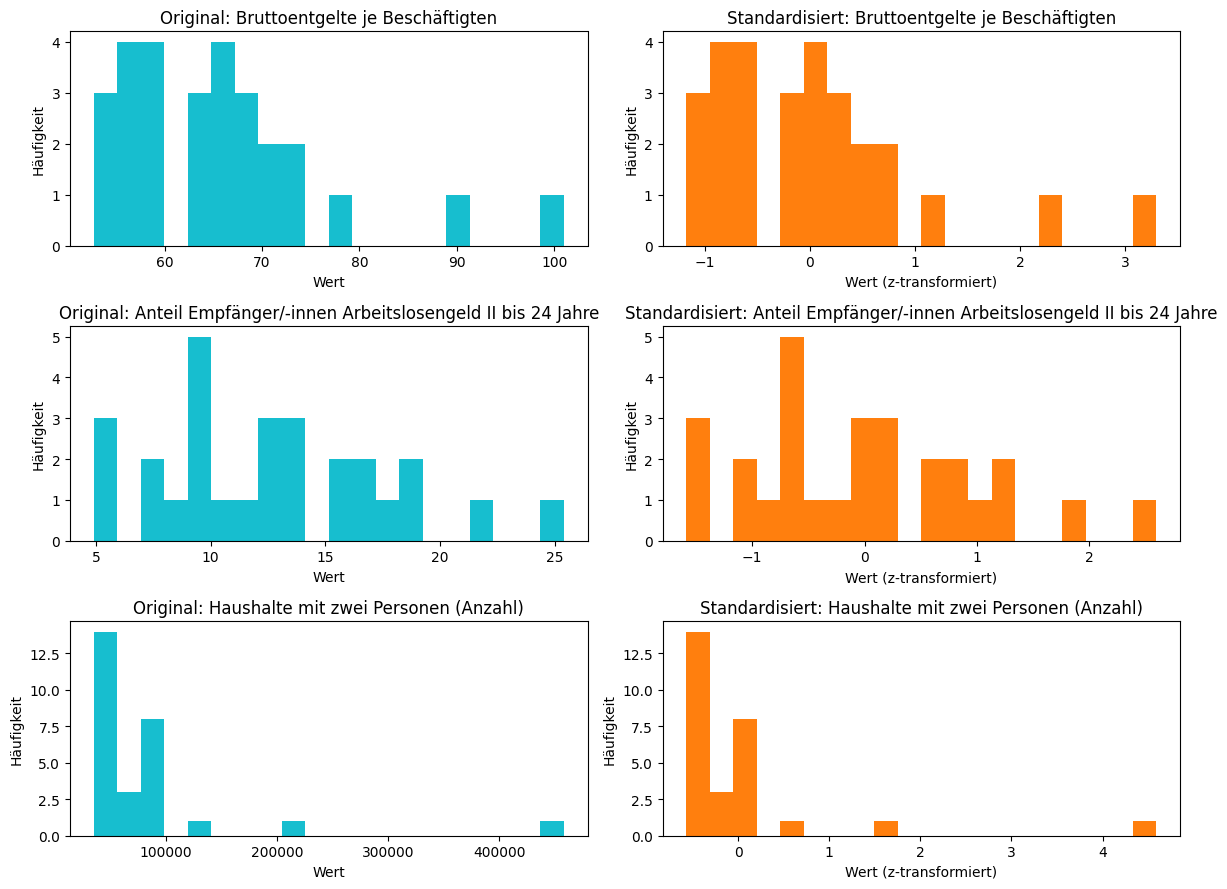

In [50]:
import matplotlib.pyplot as plt

# Liste mit gewünschten Spaltenindizes
ks = [3, 36, 42]

plt.figure(figsize=(12, 3 * len(ks)))

for i, k in enumerate(ks):
    # Original
    plt.subplot(len(ks), 2, 2*i + 1)
    plt.hist(X_clean.iloc[:, k], bins=20, color="tab:cyan")
    plt.title("Original: " + X_clean.columns[k])
    plt.xlabel("Wert")
    plt.ylabel("Häufigkeit")

    # Standardisiert
    plt.subplot(len(ks), 2, 2*i + 2)
    plt.hist(X_scaled[:, k], bins=20, color="tab:orange")
    plt.title("Standardisiert: " + X_clean.columns[k])
    plt.xlabel("Wert (z-transformiert)")
    plt.ylabel("Häufigkeit")

plt.tight_layout()
plt.show()